# Information and acknowledgments



In [ ]:
# This Jupyter notebook includes the code for CMPT419 (Affective Computing) final project.
#
# Members (Group 19):
# 1- Mehrdad Momeni zadeh (mma236@sfu.ca)
# 2- Zheng (Arthur) Li (zla229@sfu.ca)
# 3- Daniel Surina (dsa108@sfu.ca)
#
# Simon Fraser University, School of Computing Science, Burnaby, BC, Canada
#
# Instructor:
# Dr. Angelica Lim
#
# Acknowledgement:
#
# Data has been gathered from YouTube videos. It has been processed and transformed
# into frames from the original videos.
#
# Some minor parts of the below codes have been generated by the GitHub Copilot
# We used Chat-GPT to get a walkthrough of the steps we need for this project.
#
# For running the experiments at the end of this notebook, please restart the Kernel
# and run each of them individually. We inirialized the model each time, but to avoid
# any confusion, run each of them seperately please.
#
# Install the dependencies before running any of the cells please.
#
# The results have been generated in Google Colab using Nvidial A100 GPU
# Running the code using cpu or mps (MacOS) might take upto an hour just for the
# main function.
#
# Thanks to the open source communinty for implementing these great libraries.
# Feel free to reach out to any of us for any suggestions.
#
# Github repo:
# https://github.com/mehrdadmmz/rage-detector_network
#
# read the README file on our github to know more about this project.
#
# Happy coding!

# Libraries

In [ ]:
!pip install numpy tqdm matplotlib scikit-learn torch torchvision

In [ ]:
import os
import random
import numpy as np
from tqdm import tqdm
from datetime import datetime

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from torchvision import transforms, datasets, models
from torchvision.models import MobileNet_V2_Weights

# plan:
# 1- hyperparameters
# 2- setting seed
# 3- data preprocessing
# 4- model setup
# 5- loss, optimizer, and scheduler
# 6- training and validation functions
# 7- main training loop
# 8- running the model
# 9- running different experiments (separately)

In [ ]:
# # We used below code for mounting this notebook to my Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Unzipping the dataset from drive
# from zipfile import ZipFile
# file_name = "/content/drive/MyDrive/CMPT419/dataset/dataset.zip"

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

Done


# Hyperparameters

In [ ]:
# DATASET_PATH = "/content/dataset" # uncomment if uploading from the drive
DATASET_PATH = "./dataset"

BATCH_SIZE = 32
NUM_WORKERS = 8
NUM_CLASSES = 2
LEARNING_RATE = 1e-3
PIN_MEMORY = True
NUM_EPOCHS = 10
TRAINING_PORTION = 0.8
DROPOUT_RATE = 0.3

# Set Seed for Reproducibility

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True # PyTorch: Returns a bool that, if True, causes cuDNN to only use deterministic convolution algorithms.

set_seed(42)

# Data Preprocessing

In [ ]:
train_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                                       transforms.RandomRotation(20),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                      ])

val_transforms = transforms.Compose([transforms.Resize((256, 256)),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                    ])

# datasets.ImageFolder --> A generic data loader where the images are arranged in this way by default:
# root/dog/xxx.png, root/dog/xxy.png
# root/cat/123.png, root/cat/nsdf3.png
dataset = datasets.ImageFolder(DATASET_PATH,
                               transform=train_transforms) # I will change the transform of val later

train_size = int(TRAINING_PORTION * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

val_dataset.transform = val_transforms

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,)

val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,)

# Model Setup

In [ ]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

# freezing the base model parameters --> keeping learned features intact - No overfitting - faster training
for param in model.parameters():
    param.requires_grad = False

# putting the number of classes we have in the classifier
model.classifier = nn.Sequential(nn.Dropout(DROPOUT_RATE),
                                 nn.Linear(model.last_channel, NUM_CLASSES))
model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


Using cuda


100%|██████████| 13.6M/13.6M [00:00<00:00, 172MB/s]


# Loss, Optimizer, and Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

# training and validation functions

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0.0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # reset the gradients to 0
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()
        optimizer.step() # updated the model parameters

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1) # get the predicted class by finding the index with the max output val

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    # disable gradient computation for the validation
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1) # get the predicted class by finding the index with the max output val

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Helper functions

In [ ]:
# 2 helper function, one for getting the confusion matrix, and one for getting
# a heatmap out of the confusion matrix
def get_predictions(model, loader, device):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix Heatmap")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


# main training loop

In [ ]:
def main():
    num_epochs = NUM_EPOCHS
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        start_epoch = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        epoch_time = time.time() - start_epoch

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} [{epoch_time:.1f}s]: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_rage_classification_model.pth")
            print("Saved Best Model!")

    print("Training completed")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.show()

# running the model

Epoch 1/10 [31.0s]: Train Loss: 0.5675, Train Acc: 0.7086 | Val Loss: 0.4763, Val Acc: 0.7903
Saved Best Model!


Epoch 2/10 [30.8s]: Train Loss: 0.4781, Train Acc: 0.7766 | Val Loss: 0.4155, Val Acc: 0.8278
Saved Best Model!


Epoch 3/10 [30.0s]: Train Loss: 0.4519, Train Acc: 0.7912 | Val Loss: 0.3944, Val Acc: 0.8352
Saved Best Model!


Epoch 4/10 [30.1s]: Train Loss: 0.4413, Train Acc: 0.7920 | Val Loss: 0.3779, Val Acc: 0.8454
Saved Best Model!


Epoch 5/10 [29.8s]: Train Loss: 0.4294, Train Acc: 0.7986 | Val Loss: 0.3729, Val Acc: 0.8426
Saved Best Model!


Epoch 6/10 [29.7s]: Train Loss: 0.4186, Train Acc: 0.8083 | Val Loss: 0.3439, Val Acc: 0.8648
Saved Best Model!


Epoch 7/10 [29.8s]: Train Loss: 0.4257, Train Acc: 0.8039 | Val Loss: 0.3324, Val Acc: 0.8634
Saved Best Model!


Epoch 8/10 [29.7s]: Train Loss: 0.4197, Train Acc: 0.8032 | Val Loss: 0.3356, Val Acc: 0.8616


Epoch 9/10 [30.1s]: Train Loss: 0.4236, Train Acc: 0.8016 | Val Loss: 0.3292, Val Acc: 0.8653
Saved Best Model!


Epoch 10/10 [29.9s]: Train Loss: 0.4088, Train Acc: 0.8146 | Val Loss: 0.3428, Val Acc: 0.8569
Training completed


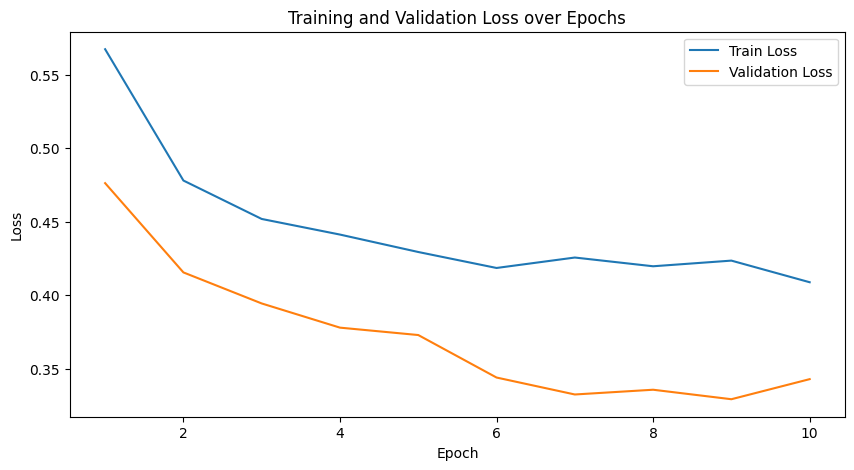

Time took: 0:05:01.451050.
Confusion Matrix:
[[964 111]
 [200 885]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1075
           1       0.89      0.82      0.85      1085

    accuracy                           0.86      2160
   macro avg       0.86      0.86      0.86      2160
weighted avg       0.86      0.86      0.86      2160



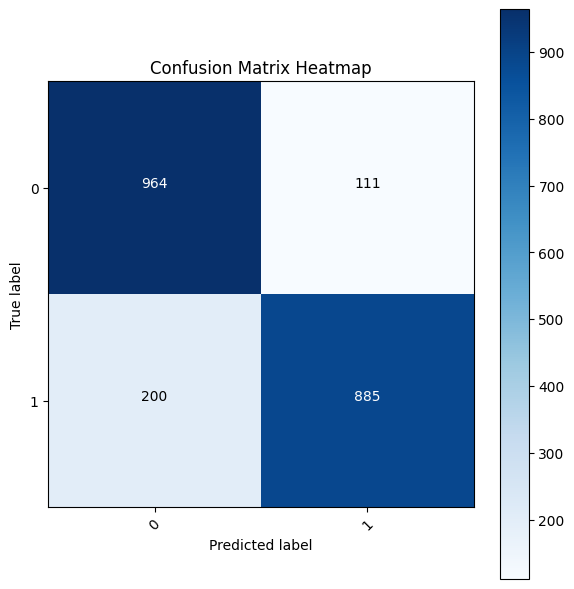

In [ ]:
if __name__ == "__main__":
    start = datetime.now()
    main()
    end = datetime.now()
    print(f"Time took: {end - start}.")

    model.load_state_dict(torch.load("best_rage_classification_model.pth"))

    preds, labels = get_predictions(model, val_loader, device)

    cm = confusion_matrix(labels, preds)
    print("Confusion Matrix:")
    print(cm)

    report = classification_report(labels, preds)
    print("Classification Report:")
    print(report)

    class_names = [str(i) for i in range(NUM_CLASSES)]
    plot_confusion_matrix(cm, class_names)

# **Exploratory Data Analysis**

# Learning Rate

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Training with learning rate: 0.01


100%|██████████| 13.6M/13.6M [00:00<00:00, 114MB/s] 


Epoch 1/10 | Train Acc: 0.6922 | Val Acc: 0.8009


Epoch 2/10 | Train Acc: 0.7068 | Val Acc: 0.7134


Epoch 3/10 | Train Acc: 0.7226 | Val Acc: 0.7963


Epoch 4/10 | Train Acc: 0.7208 | Val Acc: 0.8181


Epoch 5/10 | Train Acc: 0.7256 | Val Acc: 0.8144


Epoch 6/10 | Train Acc: 0.7229 | Val Acc: 0.7296


Epoch 7/10 | Train Acc: 0.7204 | Val Acc: 0.7347


Epoch 8/10 | Train Acc: 0.7466 | Val Acc: 0.8412


Epoch 9/10 | Train Acc: 0.7394 | Val Acc: 0.8231


Epoch 10/10 | Train Acc: 0.7412 | Val Acc: 0.8171

Training with learning rate: 0.005


Epoch 1/10 | Train Acc: 0.6954 | Val Acc: 0.7032


Epoch 2/10 | Train Acc: 0.7266 | Val Acc: 0.7755


Epoch 3/10 | Train Acc: 0.7394 | Val Acc: 0.8130


Epoch 4/10 | Train Acc: 0.7343 | Val Acc: 0.7338


Epoch 5/10 | Train Acc: 0.7455 | Val Acc: 0.8181


Epoch 6/10 | Train Acc: 0.7449 | Val Acc: 0.7593


Epoch 7/10 | Train Acc: 0.7391 | Val Acc: 0.8407


Epoch 8/10 | Train Acc: 0.7431 | Val Acc: 0.7542


Epoch 9/10 | Train Acc: 0.7324 | Val Acc: 0.8310


Epoch 10/10 | Train Acc: 0.7446 | Val Acc: 0.7995

Training with learning rate: 0.001


Epoch 1/10 | Train Acc: 0.6995 | Val Acc: 0.7866


Epoch 2/10 | Train Acc: 0.7487 | Val Acc: 0.8273


Epoch 3/10 | Train Acc: 0.7684 | Val Acc: 0.8199


Epoch 4/10 | Train Acc: 0.7611 | Val Acc: 0.8398


Epoch 5/10 | Train Acc: 0.7693 | Val Acc: 0.8181


Epoch 6/10 | Train Acc: 0.7694 | Val Acc: 0.8500


Epoch 7/10 | Train Acc: 0.7712 | Val Acc: 0.8204


Epoch 8/10 | Train Acc: 0.7728 | Val Acc: 0.8384


Epoch 9/10 | Train Acc: 0.7604 | Val Acc: 0.8486


Epoch 10/10 | Train Acc: 0.7709 | Val Acc: 0.8468

Training with learning rate: 0.0007


Epoch 1/10 | Train Acc: 0.6909 | Val Acc: 0.7718


Epoch 2/10 | Train Acc: 0.7426 | Val Acc: 0.8208


Epoch 3/10 | Train Acc: 0.7667 | Val Acc: 0.8162


Epoch 4/10 | Train Acc: 0.7659 | Val Acc: 0.8333


Epoch 5/10 | Train Acc: 0.7654 | Val Acc: 0.8301


Epoch 6/10 | Train Acc: 0.7700 | Val Acc: 0.8347


Epoch 7/10 | Train Acc: 0.7694 | Val Acc: 0.8463


Epoch 8/10 | Train Acc: 0.7713 | Val Acc: 0.8343


Epoch 9/10 | Train Acc: 0.7689 | Val Acc: 0.8481


Epoch 10/10 | Train Acc: 0.7753 | Val Acc: 0.8505

Training with learning rate: 0.0005


Epoch 1/10 | Train Acc: 0.6802 | Val Acc: 0.7532


Epoch 2/10 | Train Acc: 0.7390 | Val Acc: 0.8088


Epoch 3/10 | Train Acc: 0.7630 | Val Acc: 0.8083


Epoch 4/10 | Train Acc: 0.7627 | Val Acc: 0.8204


Epoch 5/10 | Train Acc: 0.7685 | Val Acc: 0.8222


Epoch 6/10 | Train Acc: 0.7681 | Val Acc: 0.8421


Epoch 7/10 | Train Acc: 0.7688 | Val Acc: 0.8449


Epoch 8/10 | Train Acc: 0.7736 | Val Acc: 0.8375


Epoch 9/10 | Train Acc: 0.7705 | Val Acc: 0.8375


Epoch 10/10 | Train Acc: 0.7764 | Val Acc: 0.8301

Training with learning rate: 0.0001


Epoch 1/10 | Train Acc: 0.6186 | Val Acc: 0.6810


Epoch 2/10 | Train Acc: 0.6837 | Val Acc: 0.7532


Epoch 3/10 | Train Acc: 0.7130 | Val Acc: 0.7426


Epoch 4/10 | Train Acc: 0.7266 | Val Acc: 0.7574


Epoch 5/10 | Train Acc: 0.7417 | Val Acc: 0.7796


Epoch 6/10 | Train Acc: 0.7464 | Val Acc: 0.7907


Epoch 7/10 | Train Acc: 0.7433 | Val Acc: 0.7954


Epoch 8/10 | Train Acc: 0.7602 | Val Acc: 0.7866


Epoch 9/10 | Train Acc: 0.7591 | Val Acc: 0.8005


Epoch 10/10 | Train Acc: 0.7620 | Val Acc: 0.8032

Training with learning rate: 1e-05


Epoch 1/10 | Train Acc: 0.5462 | Val Acc: 0.5704


Epoch 2/10 | Train Acc: 0.5606 | Val Acc: 0.6148


Epoch 3/10 | Train Acc: 0.5841 | Val Acc: 0.6296


Epoch 4/10 | Train Acc: 0.5990 | Val Acc: 0.6463


Epoch 5/10 | Train Acc: 0.6186 | Val Acc: 0.6500


Epoch 6/10 | Train Acc: 0.6219 | Val Acc: 0.6796


Epoch 7/10 | Train Acc: 0.6340 | Val Acc: 0.6894


Epoch 8/10 | Train Acc: 0.6472 | Val Acc: 0.6829


Epoch 9/10 | Train Acc: 0.6479 | Val Acc: 0.6870


Epoch 10/10 | Train Acc: 0.6597 | Val Acc: 0.7005


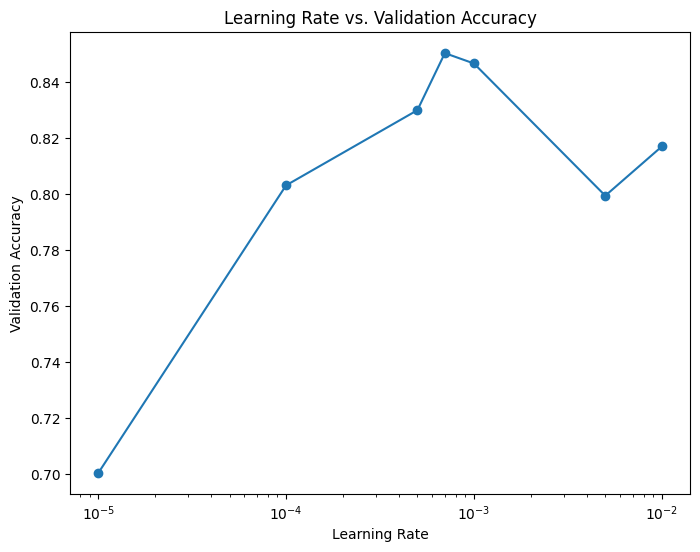

In [ ]:
import matplotlib.pyplot as plt

learning_rates = [1e-2, 5e-3, 1e-3, 7e-4, 5e-4, 1e-4, 1e-5]
results_lr = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    set_seed(42)

    model_lr = models.mobilenet_v2(pretrained=True)
    for param in model_lr.parameters():
        param.requires_grad = False
    model_lr.classifier = nn.Sequential(nn.Dropout(DROPOUT_RATE),
                                         nn.Linear(model_lr.last_channel, NUM_CLASSES))
    model_lr = model_lr.to(device)

    criterion_lr = nn.CrossEntropyLoss()
    optimizer_lr = optim.Adam(model_lr.classifier.parameters(), lr=lr)
    scheduler_lr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_lr, mode="min", factor=0.5, patience=2)

    best_val_loss = float("inf")
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_one_epoch(model_lr, train_loader, criterion_lr, optimizer_lr, device)
        val_loss, val_acc = validate(model_lr, val_loader, criterion_lr, device)
        scheduler_lr.step(val_loss)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
    results_lr[lr] = val_acc

# Plotting Learning Rate vs. Validation Accuracy
plt.figure(figsize=(8,6))
plt.plot(learning_rates, list(results_lr.values()), marker='o')
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.title("Learning Rate vs. Validation Accuracy")
plt.show()


# Dropout Rate

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Training with dropout rate: 0.1


100%|██████████| 13.6M/13.6M [00:00<00:00, 50.7MB/s]


Epoch 1/10 | Train Acc: 0.7169 | Val Acc: 0.7912


Epoch 2/10 | Train Acc: 0.7733 | Val Acc: 0.8296


Epoch 3/10 | Train Acc: 0.7969 | Val Acc: 0.8255


Epoch 4/10 | Train Acc: 0.7943 | Val Acc: 0.8426


Epoch 5/10 | Train Acc: 0.7969 | Val Acc: 0.8477


Epoch 6/10 | Train Acc: 0.8093 | Val Acc: 0.8361


Epoch 7/10 | Train Acc: 0.8015 | Val Acc: 0.8403


Epoch 8/10 | Train Acc: 0.8155 | Val Acc: 0.8662


Epoch 9/10 | Train Acc: 0.8097 | Val Acc: 0.8704


Epoch 10/10 | Train Acc: 0.8126 | Val Acc: 0.8560

Training with dropout rate: 0.3


Epoch 1/10 | Train Acc: 0.6995 | Val Acc: 0.7866


Epoch 2/10 | Train Acc: 0.7487 | Val Acc: 0.8273


Epoch 3/10 | Train Acc: 0.7684 | Val Acc: 0.8199


Epoch 4/10 | Train Acc: 0.7611 | Val Acc: 0.8398


Epoch 5/10 | Train Acc: 0.7693 | Val Acc: 0.8181


Epoch 6/10 | Train Acc: 0.7694 | Val Acc: 0.8500


Epoch 7/10 | Train Acc: 0.7712 | Val Acc: 0.8204


Epoch 8/10 | Train Acc: 0.7728 | Val Acc: 0.8384


Epoch 9/10 | Train Acc: 0.7604 | Val Acc: 0.8486


Epoch 10/10 | Train Acc: 0.7709 | Val Acc: 0.8468

Training with dropout rate: 0.5


Epoch 1/10 | Train Acc: 0.6729 | Val Acc: 0.7731


Epoch 2/10 | Train Acc: 0.7168 | Val Acc: 0.8065


Epoch 3/10 | Train Acc: 0.7287 | Val Acc: 0.8037


Epoch 4/10 | Train Acc: 0.7292 | Val Acc: 0.8222


Epoch 5/10 | Train Acc: 0.7336 | Val Acc: 0.7741


Epoch 6/10 | Train Acc: 0.7278 | Val Acc: 0.8167


Epoch 7/10 | Train Acc: 0.7249 | Val Acc: 0.8074


Epoch 8/10 | Train Acc: 0.7365 | Val Acc: 0.8130


Epoch 9/10 | Train Acc: 0.7319 | Val Acc: 0.8236


Epoch 10/10 | Train Acc: 0.7403 | Val Acc: 0.8088

Training with dropout rate: 0.7


Epoch 1/10 | Train Acc: 0.6363 | Val Acc: 0.7569


Epoch 2/10 | Train Acc: 0.6750 | Val Acc: 0.7556


Epoch 3/10 | Train Acc: 0.6740 | Val Acc: 0.7778


Epoch 4/10 | Train Acc: 0.6782 | Val Acc: 0.7866


Epoch 5/10 | Train Acc: 0.6777 | Val Acc: 0.7657


Epoch 6/10 | Train Acc: 0.6715 | Val Acc: 0.7588


Epoch 7/10 | Train Acc: 0.6801 | Val Acc: 0.7968


Epoch 8/10 | Train Acc: 0.6748 | Val Acc: 0.7690


Epoch 9/10 | Train Acc: 0.6771 | Val Acc: 0.7866


Epoch 10/10 | Train Acc: 0.6778 | Val Acc: 0.7889

Training with dropout rate: 0.9


Epoch 1/10 | Train Acc: 0.5682 | Val Acc: 0.7000


Epoch 2/10 | Train Acc: 0.5944 | Val Acc: 0.7417


Epoch 3/10 | Train Acc: 0.5935 | Val Acc: 0.7301


Epoch 4/10 | Train Acc: 0.5956 | Val Acc: 0.7343


Epoch 5/10 | Train Acc: 0.6016 | Val Acc: 0.6597


Epoch 6/10 | Train Acc: 0.5905 | Val Acc: 0.7144


Epoch 7/10 | Train Acc: 0.5767 | Val Acc: 0.7148


Epoch 8/10 | Train Acc: 0.6003 | Val Acc: 0.7296


Epoch 9/10 | Train Acc: 0.6045 | Val Acc: 0.7523


Epoch 10/10 | Train Acc: 0.6104 | Val Acc: 0.7403


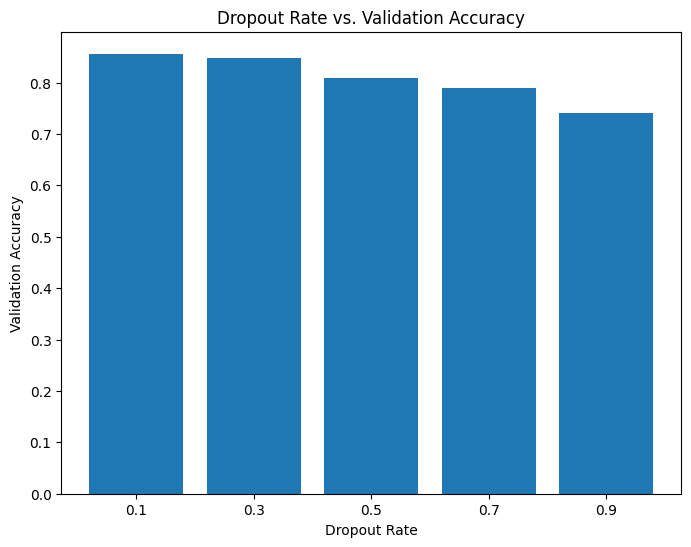

In [ ]:
dropout_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
results_dropout = {}

for dr in dropout_rates:
    print(f"\nTraining with dropout rate: {dr}")
    set_seed(42)
    model_dr = models.mobilenet_v2(pretrained=True)
    for param in model_dr.parameters():
        param.requires_grad = False
    model_dr.classifier = nn.Sequential(nn.Dropout(dr),
                                         nn.Linear(model_dr.last_channel, NUM_CLASSES))
    model_dr = model_dr.to(device)

    criterion_dr = nn.CrossEntropyLoss()
    optimizer_dr = optim.Adam(model_dr.classifier.parameters(), lr=LEARNING_RATE)
    scheduler_dr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_dr, mode="min", factor=0.5, patience=2)

    best_val_loss = float("inf")
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_one_epoch(model_dr, train_loader, criterion_dr, optimizer_dr, device)
        val_loss, val_acc = validate(model_dr, val_loader, criterion_dr, device)
        scheduler_dr.step(val_loss)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
    results_dropout[dr] = val_acc

# Plotting Dropout Rate vs. Validation Accuracy
plt.figure(figsize=(8,6))
plt.bar([str(dr) for dr in dropout_rates], list(results_dropout.values()))
plt.xlabel("Dropout Rate")
plt.ylabel("Validation Accuracy")
plt.title("Dropout Rate vs. Validation Accuracy")
plt.show()


# Batch Size

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Training with batch size: 8


100%|██████████| 13.6M/13.6M [00:00<00:00, 183MB/s]


Epoch 1/10 | Train Acc: 0.6750 | Val Acc: 0.7731


Epoch 2/10 | Train Acc: 0.7109 | Val Acc: 0.7949


Epoch 3/10 | Train Acc: 0.7148 | Val Acc: 0.7792


Epoch 4/10 | Train Acc: 0.7182 | Val Acc: 0.8231


Epoch 5/10 | Train Acc: 0.7142 | Val Acc: 0.7968


Epoch 6/10 | Train Acc: 0.7150 | Val Acc: 0.8176


Epoch 7/10 | Train Acc: 0.7172 | Val Acc: 0.8028


Epoch 8/10 | Train Acc: 0.7128 | Val Acc: 0.8005


Epoch 9/10 | Train Acc: 0.7251 | Val Acc: 0.8222


Epoch 10/10 | Train Acc: 0.7279 | Val Acc: 0.8241

Training with batch size: 16


Epoch 1/10 | Train Acc: 0.6931 | Val Acc: 0.7426


Epoch 2/10 | Train Acc: 0.7294 | Val Acc: 0.8023


Epoch 3/10 | Train Acc: 0.7471 | Val Acc: 0.8106


Epoch 4/10 | Train Acc: 0.7464 | Val Acc: 0.8162


Epoch 5/10 | Train Acc: 0.7435 | Val Acc: 0.7917


Epoch 6/10 | Train Acc: 0.7462 | Val Acc: 0.7329


Epoch 7/10 | Train Acc: 0.7442 | Val Acc: 0.8079


Epoch 8/10 | Train Acc: 0.7632 | Val Acc: 0.8356


Epoch 9/10 | Train Acc: 0.7581 | Val Acc: 0.8537


Epoch 10/10 | Train Acc: 0.7704 | Val Acc: 0.8384

Training with batch size: 32


Epoch 1/10 | Train Acc: 0.6995 | Val Acc: 0.7866


Epoch 2/10 | Train Acc: 0.7487 | Val Acc: 0.8273


Epoch 3/10 | Train Acc: 0.7684 | Val Acc: 0.8199


Epoch 4/10 | Train Acc: 0.7611 | Val Acc: 0.8398


Epoch 5/10 | Train Acc: 0.7693 | Val Acc: 0.8181


Epoch 6/10 | Train Acc: 0.7694 | Val Acc: 0.8500


Epoch 7/10 | Train Acc: 0.7712 | Val Acc: 0.8204


Epoch 8/10 | Train Acc: 0.7728 | Val Acc: 0.8384


Epoch 9/10 | Train Acc: 0.7604 | Val Acc: 0.8486


Epoch 10/10 | Train Acc: 0.7709 | Val Acc: 0.8468

Training with batch size: 64


Epoch 1/10 | Train Acc: 0.6932 | Val Acc: 0.7454


Epoch 2/10 | Train Acc: 0.7479 | Val Acc: 0.8005


Epoch 3/10 | Train Acc: 0.7705 | Val Acc: 0.8190


Epoch 4/10 | Train Acc: 0.7765 | Val Acc: 0.8259


Epoch 5/10 | Train Acc: 0.7713 | Val Acc: 0.8315


Epoch 6/10 | Train Acc: 0.7814 | Val Acc: 0.8310


Epoch 7/10 | Train Acc: 0.7840 | Val Acc: 0.8292


Epoch 8/10 | Train Acc: 0.7681 | Val Acc: 0.8375


Epoch 9/10 | Train Acc: 0.7867 | Val Acc: 0.8375


Epoch 10/10 | Train Acc: 0.7814 | Val Acc: 0.8296

Training with batch size: 128


Epoch 1/10 | Train Acc: 0.6692 | Val Acc: 0.7324


Epoch 2/10 | Train Acc: 0.7375 | Val Acc: 0.7870


Epoch 3/10 | Train Acc: 0.7567 | Val Acc: 0.8130


Epoch 4/10 | Train Acc: 0.7789 | Val Acc: 0.8116


Epoch 5/10 | Train Acc: 0.7825 | Val Acc: 0.8199


Epoch 6/10 | Train Acc: 0.7729 | Val Acc: 0.8264


Epoch 7/10 | Train Acc: 0.7863 | Val Acc: 0.8338


Epoch 8/10 | Train Acc: 0.7839 | Val Acc: 0.8315


Epoch 9/10 | Train Acc: 0.7890 | Val Acc: 0.8338


Epoch 10/10 | Train Acc: 0.7924 | Val Acc: 0.8431


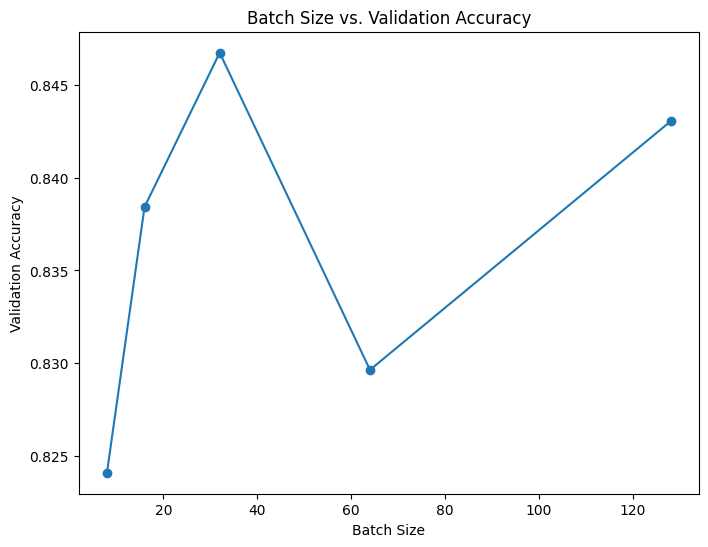

In [ ]:
batch_sizes = [8, 16, 32, 64, 128]
results_bs = {}

for bs in batch_sizes:
    print(f"\nTraining with batch size: {bs}")
    set_seed(42)

    train_loader_bs = DataLoader(train_dataset, batch_size=bs, shuffle=True,
                                 num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    val_loader_bs = DataLoader(val_dataset, batch_size=bs, shuffle=False,
                               num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    model_bs = models.mobilenet_v2(pretrained=True)
    for param in model_bs.parameters():
        param.requires_grad = False
    model_bs.classifier = nn.Sequential(nn.Dropout(DROPOUT_RATE),
                                         nn.Linear(model_bs.last_channel, NUM_CLASSES))
    model_bs = model_bs.to(device)

    criterion_bs = nn.CrossEntropyLoss()
    optimizer_bs = optim.Adam(model_bs.classifier.parameters(), lr=LEARNING_RATE)
    scheduler_bs = optim.lr_scheduler.ReduceLROnPlateau(optimizer_bs, mode="min", factor=0.5, patience=2)

    best_val_loss = float("inf")
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_one_epoch(model_bs, train_loader_bs, criterion_bs, optimizer_bs, device)
        val_loss, val_acc = validate(model_bs, val_loader_bs, criterion_bs, device)
        scheduler_bs.step(val_loss)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
    results_bs[bs] = val_acc

# Plotting Batch Size vs. Validation Accuracy
plt.figure(figsize=(8,6))
plt.plot(batch_sizes, list(results_bs.values()), marker='o')
plt.xlabel("Batch Size")
plt.ylabel("Validation Accuracy")
plt.title("Batch Size vs. Validation Accuracy")
plt.show()


# Data Augmentation Variations

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Training with No_Aug augmentation


100%|██████████| 13.6M/13.6M [00:00<00:00, 110MB/s] 


Epoch 1/10 | Train Acc: 0.7876 | Val Acc: 0.9019


Epoch 2/10 | Train Acc: 0.8515 | Val Acc: 0.9176


Epoch 3/10 | Train Acc: 0.8716 | Val Acc: 0.9356


Epoch 4/10 | Train Acc: 0.8774 | Val Acc: 0.9435


Epoch 5/10 | Train Acc: 0.8819 | Val Acc: 0.9477


Epoch 6/10 | Train Acc: 0.8884 | Val Acc: 0.9519


Epoch 7/10 | Train Acc: 0.8858 | Val Acc: 0.9583


Epoch 8/10 | Train Acc: 0.8721 | Val Acc: 0.9597


Epoch 9/10 | Train Acc: 0.8786 | Val Acc: 0.9616


Epoch 10/10 | Train Acc: 0.8806 | Val Acc: 0.9454

Training with Moderate_Aug augmentation


Epoch 1/10 | Train Acc: 0.7876 | Val Acc: 0.9019


Epoch 2/10 | Train Acc: 0.8515 | Val Acc: 0.9176


Epoch 3/10 | Train Acc: 0.8716 | Val Acc: 0.9356


Epoch 4/10 | Train Acc: 0.8774 | Val Acc: 0.9435


Epoch 5/10 | Train Acc: 0.8819 | Val Acc: 0.9477


Epoch 6/10 | Train Acc: 0.8884 | Val Acc: 0.9519


Epoch 7/10 | Train Acc: 0.8858 | Val Acc: 0.9583


Epoch 8/10 | Train Acc: 0.8721 | Val Acc: 0.9597


Epoch 9/10 | Train Acc: 0.8786 | Val Acc: 0.9616


Epoch 10/10 | Train Acc: 0.8806 | Val Acc: 0.9454

Training with Heavy_Aug augmentation


Epoch 1/10 | Train Acc: 0.7876 | Val Acc: 0.9019


Epoch 2/10 | Train Acc: 0.8515 | Val Acc: 0.9176


Epoch 3/10 | Train Acc: 0.8716 | Val Acc: 0.9356


Epoch 4/10 | Train Acc: 0.8774 | Val Acc: 0.9435


Epoch 5/10 | Train Acc: 0.8819 | Val Acc: 0.9477


Epoch 6/10 | Train Acc: 0.8884 | Val Acc: 0.9519


Epoch 7/10 | Train Acc: 0.8858 | Val Acc: 0.9583


Epoch 8/10 | Train Acc: 0.8721 | Val Acc: 0.9597


Epoch 9/10 | Train Acc: 0.8786 | Val Acc: 0.9616


Epoch 10/10 | Train Acc: 0.8806 | Val Acc: 0.9454


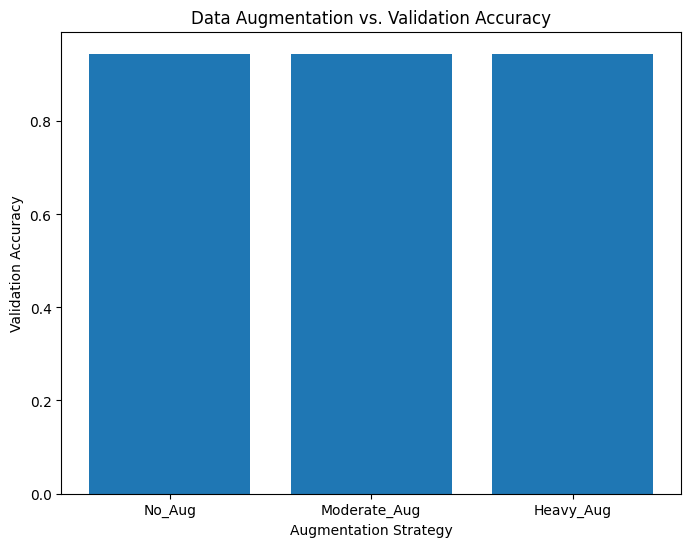

In [ ]:
# Define different transform pipelines
transforms_dict = {
    "No_Aug": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "Moderate_Aug": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "Heavy_Aug": transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

results_aug = {}

for aug_name, transform in transforms_dict.items():
    print(f"\nTraining with {aug_name} augmentation")
    set_seed(42)

    dataset_aug = datasets.ImageFolder(DATASET_PATH, transform=transform)
    train_size = int(TRAINING_PORTION * len(dataset_aug))
    val_size = len(dataset_aug) - train_size
    train_dataset_aug, val_dataset_aug = random_split(dataset_aug, [train_size, val_size])

    val_dataset_aug.dataset.transform = val_transforms

    train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE,
                                  shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    val_loader_aug = DataLoader(val_dataset_aug, batch_size=BATCH_SIZE,
                                shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    model_aug = models.mobilenet_v2(pretrained=True)
    for param in model_aug.parameters():
        param.requires_grad = False
    model_aug.classifier = nn.Sequential(nn.Dropout(DROPOUT_RATE),
                                          nn.Linear(model_aug.last_channel, NUM_CLASSES))
    model_aug = model_aug.to(device)

    criterion_aug = nn.CrossEntropyLoss()
    optimizer_aug = optim.Adam(model_aug.classifier.parameters(), lr=LEARNING_RATE)
    scheduler_aug = optim.lr_scheduler.ReduceLROnPlateau(optimizer_aug, mode="min", factor=0.5, patience=2)

    best_val_loss = float("inf")
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_one_epoch(model_aug, train_loader_aug, criterion_aug, optimizer_aug, device)
        val_loss, val_acc = validate(model_aug, val_loader_aug, criterion_aug, device)
        scheduler_aug.step(val_loss)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
    results_aug[aug_name] = val_acc

# Plotting Augmentation Type vs. Validation Accuracy
plt.figure(figsize=(8,6))
plt.bar(list(results_aug.keys()), list(results_aug.values()))
plt.xlabel("Augmentation Strategy")
plt.ylabel("Validation Accuracy")
plt.title("Data Augmentation vs. Validation Accuracy")
plt.show()


# Freezing vs. Fine-Tuning

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Training with Freeze


100%|██████████| 13.6M/13.6M [00:00<00:00, 95.9MB/s]


Epoch 1/10 | Train Acc: 0.6995 | Val Acc: 0.7866


Epoch 2/10 | Train Acc: 0.7487 | Val Acc: 0.8273


Epoch 3/10 | Train Acc: 0.7684 | Val Acc: 0.8199


Epoch 4/10 | Train Acc: 0.7611 | Val Acc: 0.8398


Epoch 5/10 | Train Acc: 0.7693 | Val Acc: 0.8181


Epoch 6/10 | Train Acc: 0.7694 | Val Acc: 0.8500


Epoch 7/10 | Train Acc: 0.7712 | Val Acc: 0.8204


Epoch 8/10 | Train Acc: 0.7728 | Val Acc: 0.8384


Epoch 9/10 | Train Acc: 0.7604 | Val Acc: 0.8486


Epoch 10/10 | Train Acc: 0.7709 | Val Acc: 0.8468

Training with FineTune


Epoch 1/10 | Train Acc: 0.8821 | Val Acc: 0.9741


Epoch 2/10 | Train Acc: 0.9630 | Val Acc: 0.9810


Epoch 3/10 | Train Acc: 0.9795 | Val Acc: 0.9917


Epoch 4/10 | Train Acc: 0.9806 | Val Acc: 0.9926


Epoch 5/10 | Train Acc: 0.9806 | Val Acc: 0.9861


Epoch 6/10 | Train Acc: 0.9860 | Val Acc: 0.9824


Epoch 7/10 | Train Acc: 0.9861 | Val Acc: 0.9894


Epoch 8/10 | Train Acc: 0.9957 | Val Acc: 0.9991


Epoch 9/10 | Train Acc: 0.9973 | Val Acc: 0.9977


Epoch 10/10 | Train Acc: 0.9983 | Val Acc: 0.9977


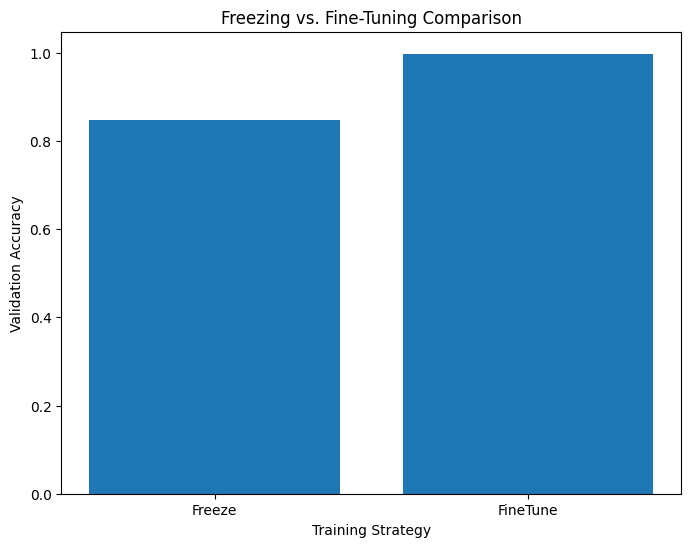

In [ ]:
freezing_options = {"Freeze": True, "FineTune": False}
results_ft = {}

for option, freeze in freezing_options.items():
    print(f"\nTraining with {option}")
    set_seed(42)
    model_ft = models.mobilenet_v2(pretrained=True)
    if freeze:
        for param in model_ft.parameters():
            param.requires_grad = False

    model_ft.classifier = nn.Sequential(nn.Dropout(DROPOUT_RATE),
                                         nn.Linear(model_ft.last_channel, NUM_CLASSES))
    model_ft = model_ft.to(device)

    criterion_ft = nn.CrossEntropyLoss()
    if freeze:
        optimizer_ft = optim.Adam(model_ft.classifier.parameters(), lr=LEARNING_RATE)
    else:
        optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)
    scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode="min", factor=0.5, patience=2)

    best_val_loss = float("inf")
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_one_epoch(model_ft, train_loader, criterion_ft, optimizer_ft, device)
        val_loss, val_acc = validate(model_ft, val_loader, criterion_ft, device)
        scheduler_ft.step(val_loss)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
    results_ft[option] = val_acc

# Plotting Freezing vs. Fine-Tuning
plt.figure(figsize=(8,6))
plt.bar(list(results_ft.keys()), list(results_ft.values()))
plt.xlabel("Training Strategy")
plt.ylabel("Validation Accuracy")
plt.title("Freezing vs. Fine-Tuning Comparison")
plt.show()


# Optimizer Comparison


Training with AdamW


Epoch 1/10 | Train Acc: 0.6998 | Val Acc: 0.7866


Epoch 2/10 | Train Acc: 0.7488 | Val Acc: 0.8273


Epoch 3/10 | Train Acc: 0.7684 | Val Acc: 0.8199


Epoch 4/10 | Train Acc: 0.7612 | Val Acc: 0.8398


Epoch 5/10 | Train Acc: 0.7697 | Val Acc: 0.8181


Epoch 6/10 | Train Acc: 0.7691 | Val Acc: 0.8495


Epoch 7/10 | Train Acc: 0.7708 | Val Acc: 0.8194


Epoch 8/10 | Train Acc: 0.7726 | Val Acc: 0.8380


Epoch 9/10 | Train Acc: 0.7605 | Val Acc: 0.8486


Epoch 10/10 | Train Acc: 0.7708 | Val Acc: 0.8454

Training with Adam


Epoch 1/10 | Train Acc: 0.6995 | Val Acc: 0.7866


Epoch 2/10 | Train Acc: 0.7487 | Val Acc: 0.8273


Epoch 3/10 | Train Acc: 0.7684 | Val Acc: 0.8199


Epoch 4/10 | Train Acc: 0.7611 | Val Acc: 0.8398


Epoch 5/10 | Train Acc: 0.7693 | Val Acc: 0.8181


Epoch 6/10 | Train Acc: 0.7694 | Val Acc: 0.8500


Epoch 7/10 | Train Acc: 0.7712 | Val Acc: 0.8204


Epoch 8/10 | Train Acc: 0.7728 | Val Acc: 0.8384


Epoch 9/10 | Train Acc: 0.7604 | Val Acc: 0.8486


Epoch 10/10 | Train Acc: 0.7709 | Val Acc: 0.8468

Training with SGD


Epoch 1/10 | Train Acc: 0.6946 | Val Acc: 0.7806


Epoch 2/10 | Train Acc: 0.7470 | Val Acc: 0.8245


Epoch 3/10 | Train Acc: 0.7672 | Val Acc: 0.8162


Epoch 4/10 | Train Acc: 0.7664 | Val Acc: 0.8333


Epoch 5/10 | Train Acc: 0.7648 | Val Acc: 0.8278


Epoch 6/10 | Train Acc: 0.7703 | Val Acc: 0.8333


Epoch 7/10 | Train Acc: 0.7684 | Val Acc: 0.8449


Epoch 8/10 | Train Acc: 0.7705 | Val Acc: 0.8366


Epoch 9/10 | Train Acc: 0.7667 | Val Acc: 0.8468


Epoch 10/10 | Train Acc: 0.7755 | Val Acc: 0.8472


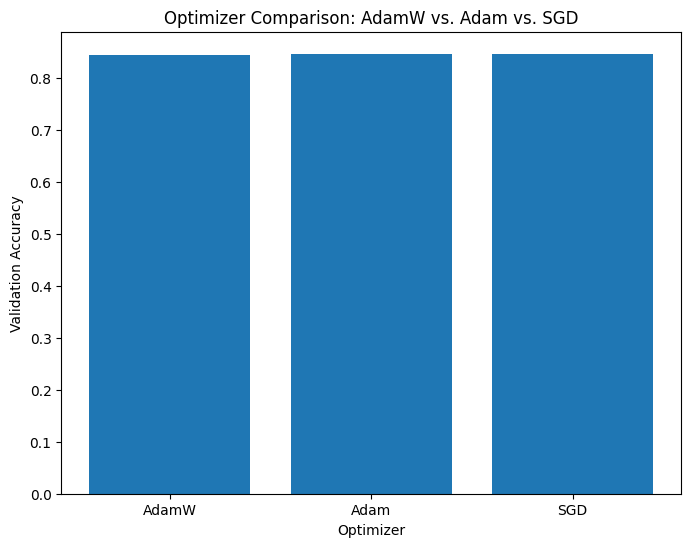

In [ ]:
optimizer_options = {"AdamW": optim.AdamW, "Adam": optim.Adam, "SGD": optim.SGD}
results_opt = {}

for opt_name, opt_class in optimizer_options.items():
    print(f"\nTraining with {opt_name}")
    set_seed(42)
    model_opt = models.mobilenet_v2(pretrained=True)
    for param in model_opt.parameters():
        param.requires_grad = False
    model_opt.classifier = nn.Sequential(nn.Dropout(DROPOUT_RATE),
                                          nn.Linear(model_opt.last_channel, NUM_CLASSES))
    model_opt = model_opt.to(device)

    criterion_opt = nn.CrossEntropyLoss()

    if opt_name == "SGD":
        optimizer_opt = opt_class(model_opt.classifier.parameters(), lr=LEARNING_RATE, momentum=0.9)
    else:
        optimizer_opt = opt_class(model_opt.classifier.parameters(), lr=LEARNING_RATE)

    scheduler_opt = optim.lr_scheduler.ReduceLROnPlateau(optimizer_opt, mode="min", factor=0.5, patience=2)

    best_val_loss = float("inf")
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_one_epoch(model_opt, train_loader, criterion_opt, optimizer_opt, device)
        val_loss, val_acc = validate(model_opt, val_loader, criterion_opt, device)
        scheduler_opt.step(val_loss)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
    results_opt[opt_name] = val_acc

# Plotting Optimizer Comparison
plt.figure(figsize=(8,6))
plt.bar(list(results_opt.keys()), list(results_opt.values()))
plt.xlabel("Optimizer")
plt.ylabel("Validation Accuracy")
plt.title("Optimizer Comparison: AdamW vs. Adam vs. SGD")
plt.show()